# Импорты и общие настройки

In [34]:
import os, re, math, warnings, csv, glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

try:
    import pywt
    HAVE_PYWT = True
except Exception:
    pywt = None
    HAVE_PYWT = False

# reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds(42)


# Парсер M3 (.tsf c двоеточиями) → TRAIN/TSTS

In [35]:
# Путь к TSF-исходникам (Monash/Forvision колоночный формат "name:timestamp:v1,...")
TSF_ROOT = r"C:\Users\Admin\Desktop\NIR\mnt\data\datasets\M3"
OUT_DIR  = r"/mnt/data"  # можно заменить на TSF_ROOT, если хочешь сохранять рядом

TSF_FILES = {
    "yearly":    os.path.join(TSF_ROOT, "m3_yearly_dataset.tsf"),
    "quarterly": os.path.join(TSF_ROOT, "m3_quarterly_dataset.tsf"),
    "monthly":   os.path.join(TSF_ROOT, "m3_monthly_dataset.tsf"),
    # "other":   os.path.join(TSF_ROOT, "m3_other_dataset.tsf"),  # добавь при наличии
}
H_BY_FREQ = {"yearly":6, "quarterly":8, "monthly":18, "other":8}
M_BY_FREQ = {"yearly":1, "quarterly":4, "monthly":12, "other":1}

def parse_colon_tsf(path):
    lines = open(path, "r", encoding="utf-8", errors="ignore").read().splitlines()
    i = 0
    while i < len(lines) and not lines[i].strip().lower().startswith("@data"):
        i += 1
    i += 1
    series = []
    for s in lines[i:]:
        s = s.strip()
        if not s or s.startswith("#"): 
            continue
        first = s.find(":")
        if first < 0: 
            continue
        second = s.find(":", first+1)
        if second < 0:
            continue
        name = s[:first].strip()
        # start_ts = s[first+1:second].strip()  # не используем
        values_str = s[second+1:].strip()
        vals = []
        for tok in values_str.split(","):
            tok = tok.strip().replace(" ", "")
            if tok in ("", "?"): 
                continue
            try:
                vals.append(float(tok))
            except:
                m = re.match(r"^([+-]?\d+(?:\.\d+)?)", tok)
                if m:
                    try: vals.append(float(m.group(1)))
                    except: pass
        series.append((name, vals))
    return series

def export_train_tsts(freq, items, out_dir=OUT_DIR):
    H = H_BY_FREQ[freq]
    rows_tr, rows_te = [], []
    for sid, vals in items:
        if not isinstance(vals, list) or len(vals) <= H:
            continue
        y_tr, y_te = vals[:-H], vals[-H:]
        n_tr, n_te = len(y_tr), len(y_te)
        rows_tr.append(pd.DataFrame({"series_id": sid, "timestamp": np.arange(1, n_tr+1), "value": y_tr}))
        rows_te.append(pd.DataFrame({"series_id": sid, "timestamp": np.arange(n_tr+1, n_tr+n_te+1), "value": y_te}))
    df_tr = pd.concat(rows_tr, ignore_index=True) if rows_tr else pd.DataFrame(columns=["series_id","timestamp","value"])
    df_te = pd.concat(rows_te, ignore_index=True) if rows_te else pd.DataFrame(columns=["series_id","timestamp","value"])
    os.makedirs(out_dir, exist_ok=True)
    p_tr = os.path.join(out_dir, f"M3_{freq}_TRAIN.csv")
    p_te = os.path.join(out_dir, f"M3_{freq}_TSTS.csv")
    df_tr.to_csv(p_tr, index=False); df_te.to_csv(p_te, index=False)
    print(f"[{freq}] train={len(df_tr)} rows, test={len(df_te)} rows -> {p_tr}, {p_te}")

# Выполнить однократно (или комментировать, если уже есть CSV)
for freq, path in TSF_FILES.items():
    if os.path.exists(path):
        items = parse_colon_tsf(path)
        export_train_tsts(freq, items, OUT_DIR)


[yearly] train=14449 rows, test=3870 rows -> /mnt/data\M3_yearly_TRAIN.csv, /mnt/data\M3_yearly_TSTS.csv
[quarterly] train=30956 rows, test=6048 rows -> /mnt/data\M3_quarterly_TRAIN.csv, /mnt/data\M3_quarterly_TSTS.csv
[monthly] train=141858 rows, test=25704 rows -> /mnt/data\M3_monthly_TRAIN.csv, /mnt/data\M3_monthly_TSTS.csv


# Утилиты: метрики, датасет окон, период/окно, бейзлайн

In [36]:
def sMAPE(y, yhat, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return 200*np.mean(np.abs(yhat-y)/(np.abs(y)+np.abs(yhat)+eps))

def MAPE(y, yhat, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return 100*np.mean(np.abs((yhat-y)/(y+eps)))

def _naive_scale(y, m=1):
    y = np.asarray(y, float)
    return (np.mean(np.abs(y[m:]-y[:-m])) if len(y)>m else np.mean(np.abs(np.diff(y)))) + 1e-8

def MASE(y, yhat, y_train, m=1):
    return np.mean(np.abs(np.asarray(yhat)-np.asarray(y))) / _naive_scale(y_train, m=m)

def seasonal_naive(y_train, H, m=1):
    y_train = np.asarray(y_train, float); m=max(1,int(m))
    if len(y_train) < m: return np.repeat(y_train[-1], H)
    reps = int(math.ceil(H/m))
    return np.tile(y_train[-m:], reps)[:H]

def best_period_fft(y_tr, max_p=336, min_len_for_fft=8):
    y_tr = np.asarray(y_tr, float)
    if len(y_tr) < min_len_for_fft: return 1
    yt = y_tr - y_tr.mean()
    try: F = np.abs(np.fft.rfft(yt))
    except ValueError: return 1
    if F.size <= 1: return 1
    F[0]=0.0; T = len(y_tr); b = int(np.argmax(F[1:]))+1
    p = int(round(T/b)) if b>0 else 1
    return 1 if (p<1 or p>max_p) else p

def safe_lookback(n, want_L, H, min_L=16):
    Lmax = max(min_L, n - H)
    return int(max(min_L, min(want_L, Lmax)))

class WindowDatasetStd(Dataset):
    def __init__(self, y, lookback, horizon, stride=1, scale=True):
        y = np.asarray(y, dtype=np.float32)
        self.mu, self.sd = (y.mean(), y.std()+1e-8) if scale else (0.0, 1.0)
        z = (y - self.mu)/self.sd if scale else y
        X, Y = [], []
        for t in range(0, len(z)-lookback-horizon+1, stride):
            X.append(z[t:t+lookback]); Y.append(z[t+lookback:t+lookback+horizon])
        self.X = np.asarray(X, dtype=np.float32); self.Y = np.asarray(Y, dtype=np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): 
        return torch.from_numpy(self.X[i]).unsqueeze(0), torch.from_numpy(self.Y[i])
    @property
    def scaler(self): return (float(self.mu), float(self.sd))


# Модели: TimesNetV2, NBEATSV2, SWT-гибрид

In [37]:
class MSUnit(nn.Module):
    def __init__(self, in_ch=1, d_model=32):
        super().__init__()
        self.act = nn.GELU()
        # без паддинга в Conv2d — будем паддить вручную слева
        self.p3 = nn.Conv2d(in_ch, d_model, kernel_size=(3,1), padding=0, bias=False)
        self.p5 = nn.Conv2d(in_ch, d_model, kernel_size=(5,1), padding=0, bias=False)
        self.f3 = nn.Conv2d(in_ch, d_model, kernel_size=(1,3), padding=0, bias=False)
        self.f5 = nn.Conv2d(in_ch, d_model, kernel_size=(1,5), padding=0, bias=False)

        self.proj = nn.Conv2d(4*d_model, in_ch, kernel_size=1, bias=False)
        self.norm = nn.GroupNorm(1, 4*d_model)

    def _causal_T(self, conv, x):
        kT = conv.kernel_size[0]
        # паддинг слева по временной оси (height)
        x_pad = F.pad(x, (0,0, kT-1, 0))  # (left,right, top, bottom) по (W,H)
        return conv(x_pad)

    def _causal_F(self, conv, x):
        kF = conv.kernel_size[1]
        x_pad = F.pad(x, (kF-1, 0, 0, 0))
        return conv(x_pad)

    def forward(self, x):
        a = self.act(self._causal_T(self.p3, x))
        b = self.act(self._causal_T(self.p5, x))
        c = self.act(self._causal_F(self.f3, x))
        d = self.act(self._causal_F(self.f5, x))
        y = torch.cat([a,b,c,d], dim=1)
        y = self.norm(y)
        y = self.proj(y)
        return y


class TimesBlockV2(nn.Module):
    def __init__(self, lookback, horizon, d_model=32, topk=2):
        super().__init__()
        self.horizon = horizon
        self.topk = topk
        self.msunit = MSUnit(1, d_model)
        # ГОЛОВА: проекция по времени T -> H
        self.head = nn.Linear(lookback, horizon)
    def _reshape_2d(self, x, P):
        B,_,T = x.shape; cols = (T+P-1)//P; Tpad=P*cols; pad=Tpad-T
        if pad>0: x = torch.cat([x, torch.zeros(B,1,pad, device=x.device, dtype=x.dtype)], dim=-1)
        return x.view(B,1,cols,P).transpose(-1,-2).contiguous(), pad, T
    def _reshape_back(self, x2d, pad, T):
        B,C,P,F = x2d.shape; x = x2d.transpose(-1,-2).contiguous().view(B,C,P*F)
        if pad>0: x = x[...,:x.shape[-1]-pad]
        if x.shape[-1]!=T: x = x[...,:T]
        return x
    def forward(self, x):
        T = x.shape[-1]
        amp = torch.fft.rfft(x[:,0,:], dim=-1).abs().mean(0)[1:]
        k = int(min(self.topk, amp.numel()))
        if k<=0: P_list=[T]; weights=torch.tensor([1.0], device=x.device, dtype=x.dtype)
        else:
            vals, idx = torch.topk(amp, k); freqs=(idx+1)
            P_list = [max(1, int(round(T/int(f.item())))) for f in freqs]
            weights = torch.softmax(vals.to(x.device, dtype=x.dtype), dim=0)
        outs=[]
        for P in P_list:
            x2d, pad, T0 = self._reshape_2d(x, P)
            y2d = self.msunit(x2d)
            y1d = self._reshape_back(y2d, pad, T0)
            outs.append(y1d)
        y = torch.zeros_like(x)
        for w, yi in zip(weights, outs):
            y = y + w * yi
        y_flat = y.squeeze(1)          # (B, T)
        out = self.head(y_flat)        # (B, H)
        return out

class TimesNetV2(nn.Module):
    def __init__(self, lookback, horizon, d_model=32, layers=2, topk=2):
        super().__init__()
        self.blocks = nn.ModuleList([
            TimesBlockV2(lookback, horizon, d_model, topk) 
            for _ in range(layers)
        ])
        self.horizon = horizon
        self.head = None

    def forward(self, x):
        out = None
        y = x
        for blk in self.blocks:
            f = blk(y)                 # (B,H)
            out = f if out is None else (out + f)
        anchor = x[:, :, -1].squeeze(1).unsqueeze(1)   # (B,1)
        out = out + anchor                              # якорим уровень на последнюю точку
        return out                   # (B, H)

class NBEATBlock(nn.Module):
    def __init__(self, backcast, forecast, width=128, depth=2):
        super().__init__(); layers=[]; n=backcast
        for _ in range(depth): layers += [nn.Linear(n, width), nn.ReLU()]; n=width
        self.fc = nn.Sequential(*layers); self.theta_b = nn.Linear(width, backcast); self.theta_f = nn.Linear(width, forecast)
    def forward(self, x):
        h = self.fc(x); return self.theta_b(h), self.theta_f(h)

class NBEATSV2(nn.Module):
    def __init__(self, lookback, horizon, width=128, depth=2, nblocks=2):
        super().__init__(); self.blocks=nn.ModuleList([NBEATBlock(lookback,horizon,width,depth) for _ in range(nblocks)]); self.horizon=horizon
    def forward(self, x):
        B,C,T = x.shape; backcast = x.view(B,T); forecast = torch.zeros(B, self.horizon, device=x.device, dtype=x.dtype)
        for blk in self.blocks:
            b,f = blk(backcast); backcast = backcast - b; forecast = forecast + f
        anchor = x[:, :, -1].squeeze(1).unsqueeze(1)   # (B,1)
        forecast = forecast + anchor                              # якорим уровень на последнюю точку
        return forecast

# === Robust external MODWT glue (no SWT, no pywt.MODWT; only your /mnt/data/modwt.py) ===
import os, importlib.util, numpy as np
try:
    import pywt
    LENS_CACHE = {}
    def _flt_len(w):
        if w in LENS_CACHE: return LENS_CACHE[w]
        LENS_CACHE[w] = len(pywt.Wavelet(w).dec_lo)
        return LENS_CACHE[w]
except Exception:
    pywt = None
    def _flt_len(w): return 8   # разумный дефолт, если pywt недоступен

# загрузка твоего модуля
EXT_MODWT = "modwt.py"
assert os.path.exists(EXT_MODWT), f"Не найден файл с реализацией MODWT: {EXT_MODWT}"
_spec = importlib.util.spec_from_file_location("ext_modwt", EXT_MODWT)
ext_modwt = importlib.util.module_from_spec(_spec); _spec.loader.exec_module(ext_modwt)

def _jmax_for_len(n:int, L:int) -> int:
    """Максимальный уровень для MODWT при длине ряда n и длине фильтра L.
       Условие: 2^(J-1)*(L-1) < n  (смещение эффективного ядра меньше длины сигнала)."""
    if n <= 2: return 1
    J = 1
    while (2**(J-1))*(L-1) < n:
        J += 1
    return max(1, J-1)

def wavelet_decompose_modwt(y, wavelet='db4', level=1, *, check=True, verbose=False):
    """Только внешний MODWT: возвращает (A_J, [D_J, ..., D_1]) длиной N.
       Бросает информативные ошибки вместо скрытого None."""
    y = np.asarray(y, float)
    N = int(y.size)
    if N < 2:
        return y, []

    L = _flt_len(wavelet)
    Jmax = _jmax_for_len(N, L)
    J = int(max(1, min(level, Jmax)))

    # вызываем твою реализацию
    W = ext_modwt.modwt(y, wavelet, J)              # ожидаем (J+1, N) или последовательность
    M = ext_modwt.modwtmra(W, wavelet)              # ожидаем [D1..DJ, A_J] или массив (J+1, N)

    # приведение и проверки
    if isinstance(M, (list, tuple)):
        comps = [np.asarray(c, dtype=float) for c in M]
        arr = np.vstack(comps)
    else:
        arr = np.asarray(M, dtype=float)

    if check:
        if arr.ndim != 2:
            raise ValueError(f"modwtmra вернул ndim={arr.ndim}, ожидалось 2 (получено тип {type(M)}).")
        r, c = arr.shape
        if r != J+1 or c != N:
            raise ValueError(f"modwtmra форма {arr.shape}, ожидалось ({J+1}, {N}). "
                             f"wavelet={wavelet}, J={J}, N={N}, L={L}")
    if verbose:
        print(f"[MODWT ext] wavelet={wavelet} L={L} N={N} J={J}  arr.shape={arr.shape}")

    A = arr[-1]            # A_J
    D = [arr[j] for j in range(J-1, -1, -1)]  # [D_J..D_1]
    return A, D

class TrainConfig:
    def __init__(self, lookback, horizon, epochs=10, batch_size=64, lr=3e-3, weight_decay=1e-4,
                 topk=2, layers=2, width=128, depth=2, nblocks=2, wavelet='db4', level=2, device=None, clip=1.0):
        self.lookback=lookback; self.horizon=horizon; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.weight_decay=weight_decay; self.topk=topk; self.layers=layers
        self.width=width; self.depth=depth; self.nblocks=nblocks
        self.wavelet=wavelet; self.level=level; self.clip=clip
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

def _make_model(name, cfg):
    if name=='timesnet': 
        return TimesNetV2(cfg.lookback, cfg.horizon, d_model=32, layers=cfg.layers, topk=cfg.topk)
    if name=='nbeats':
        return NBEATSV2(cfg.lookback, cfg.horizon, width=cfg.width, depth=cfg.depth, nblocks=cfg.nblocks)
    raise ValueError

def _train(model, ds, cfg):
    if len(ds)==0: return None
    dl = DataLoader(ds, batch_size=cfg.batch_size, shuffle=True)
    dev = cfg.device; model = model.to(dev)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    lossf = nn.MSELoss(); model.train()
    for _ in range(cfg.epochs):
        for xb,yb in dl:
            xb=xb.to(dev).float(); yb=yb.to(dev).float()
            opt.zero_grad(); yhat=model(xb); loss=lossf(yhat,yb); loss.backward()
            if cfg.clip is not None: nn.utils.clip_grad_norm_(model.parameters(), cfg.clip)
            opt.step()
    model.eval(); return model

def _forecast(model, x_last, mu, sd, cfg):
    with torch.no_grad():
        xb = torch.from_numpy(((x_last-mu)/sd).astype(np.float32)).reshape(1,1,-1).to(cfg.device)
        pred = model(xb).cpu().numpy().ravel()
    return pred*sd + mu

def linear_extrapolation(x_last, H):
    z = np.asarray(x_last, float)
    t = np.arange(len(z))
    A = np.vstack([t, np.ones_like(t)]).T
    a,b = np.linalg.lstsq(A, z, rcond=None)[0]
    tf = np.arange(len(z), len(z)+H)
    return a*tf + b

# --- Обновляем HybridPlus: жёстко MODWT из внешнего файла, безопасное поведение на уровне компонентов
class HybridPlus:
    """MODWT(/mnt/data/modwt.py) + (TimesNetV2 | NBEATSV2). Параметры method/прочие игнорируются."""
    def __init__(self, base: str, cfg, **kwargs):
        self.base = base
        self.cfg = cfg
        self.models = []
        self.lookbacks = []

    def fit(self, y):
        y = np.asarray(y, float)
        A, D = wavelet_decompose_modwt(y, wavelet=self.cfg.wavelet, level=self.cfg.level, check=True)
        comps = [A] + D if len(D) else [A]
        self.models, self.lookbacks = [], []
        for comp in comps:
            Lmax = len(comp) - self.cfg.horizon
            if Lmax < 16:
                # слишком короткая компонента — пропустим
                self.models.append(None); self.lookbacks.append(None); continue
            L = min(self.cfg.lookback, Lmax)
            ds = WindowDatasetStd(comp, L, self.cfg.horizon, stride=1, scale=True)
            mu, sd = ds.scaler
            m = _make_model(self.base, self.cfg)
            m = _train(m, ds, self.cfg)
            self.models.append((m, mu, sd)); self.lookbacks.append(L)
        return self

    def forecast(self, y):
        y = np.asarray(y, float); H = self.cfg.horizon
        A, D = wavelet_decompose_modwt(y, wavelet=self.cfg.wavelet, level=self.cfg.level, check=True)
        comps = [A] + D if len(D) else [A]
        preds = []
        for info, Lc, comp in zip(self.models, self.lookbacks, comps):
            if info is None or Lc is None: 
                continue
            m, mu, sd = info
            xb = ((comp[-Lc:] - mu)/sd).astype(np.float32).reshape(1,1,-1)
            with torch.no_grad():
                p = m(torch.from_numpy(xb).to(self.cfg.device)).cpu().numpy().ravel()
            preds.append(p*sd + mu)
        if not preds:
            # ряд слишком короткий / все компоненты пропущены — отдаём «последнее значение»
            return np.repeat(y[-1], H).astype(float)
        yhat = np.sum(np.stack(preds, 0), axis=0)
        if yhat.size != H:
            yhat = yhat[:H] if yhat.size>H else np.pad(yhat, (0, H-yhat.size), mode='edge')
        return yhat

print("[OK] Включён ТОЛЬКО внешний MODWT; контроль форм и уровня J добавлен. Никаких SWT/pywt.modwt.")



[OK] Включён ТОЛЬКО внешний MODWT; контроль форм и уровня J добавлен. Никаких SWT/pywt.modwt.


# Загрузчик TRAIN/TSTS и конфиг

In [38]:
ROOT = OUT_DIR  # где лежат M3_*_{TRAIN,TSTS}.csv

FILES = {
    "yearly":    ("M3_yearly_TRAIN.csv",    "M3_yearly_TSTS.csv"),
    "quarterly": ("M3_quarterly_TRAIN.csv", "M3_quarterly_TSTS.csv"),
    "monthly":   ("M3_monthly_TRAIN.csv",   "M3_monthly_TSTS.csv"),
    # "other":   ("M3_other_TRAIN.csv",     "M3_other_TSTS.csv"),
}

def _read_tidy(path):
    df = pd.read_csv(path, engine="python")
    df.columns = [c.strip().lower() for c in df.columns]
    df = df[["series_id","timestamp","value"]].copy()
    df["series_id"] = df["series_id"].astype(str)
    if not np.issubdtype(df["timestamp"].dtype, np.number):
        df["timestamp"] = pd.factorize(df["timestamp"])[0] + 1
    df["timestamp"] = df["timestamp"].astype(int)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["value"])
    return df

def load_m3_tidy(category, strict_h=True):
    tr_name, te_name = FILES[category]
    p_tr = os.path.join(ROOT, tr_name); p_te = os.path.join(ROOT, te_name)
    df_tr = _read_tidy(p_tr); df_te = _read_tidy(p_te)
    H = H_BY_FREQ[category]; out=[]
    for sid, gtr in df_tr.groupby("series_id", sort=False):
        y_tr = gtr.sort_values("timestamp")["value"].to_numpy(float)
        gte  = df_te[df_te["series_id"]==sid].sort_values("timestamp")
        if gte.empty or len(y_tr)<2: continue
        y_te = gte["value"].to_numpy(float)
        if strict_h and len(y_te) >= H: y_te = y_te[-H:]
        out.append((sid, y_tr, y_te))
    return out

def make_cfg(y_tr, H, cat, epochs=8):
    per = M_BY_FREQ.get(cat,1)
    if per==1:
        per = best_period_fft(y_tr)
    # Lookback под M3
    if cat == "monthly":
        base_L = max(2*per, 72)       # было 96
        level  = 2                    # SWT
        epochs = max(8, epochs)
    elif cat == "quarterly":
        base_L = max(3*per, 48)
        level  = 1
        epochs = max(8, epochs)
    else:  # yearly
        base_L = max(3*per, 36)
        level  = 1
        epochs = max(10, epochs)

    L = safe_lookback(len(y_tr), base_L, H, min_L=16)
    return TrainConfig(lookback=L, horizon=H, epochs=epochs,
                       level=level, layers=3, topk=2,
                       width=256, depth=3, nblocks=3,
                       lr=3e-3, weight_decay=1e-4, clip=1.0), per, L




# Визуализация и основная оценка

In [39]:
def plot_forecast(title, y_tr, y_te, forecasts: dict, save_path=None):
    H = len(y_te); xtr = np.arange(len(y_tr)); xte = np.arange(len(y_tr), len(y_tr)+H)
    plt.figure()
    plt.plot(xtr, y_tr, label='train'); plt.plot(xte, y_te, label='test')
    for k,v in forecasts.items():
        if v is None:
            print(f"[plot] {k}: no forecast (fallback used elsewhere?)")
            continue
        plt.plot(xte, v, label=k)
    plt.title(title); plt.xlabel("t"); plt.ylabel("y"); plt.legend()
    if save_path: plt.savefig(save_path, bbox_inches="tight"); plt.close()
    else: plt.show()

def eval_and_plot_m3(categories=("yearly","quarterly","monthly"),
                     n_per_cat=8, pick="random", seed=42, epochs=8,
                     out_prefix="/mnt/data/m3_ours"):
    rng = np.random.default_rng(seed)
    results=[]; images=[]
    for cat in categories:
        groups = load_m3_tidy(cat, strict_h=True)
        if not groups: 
            print(f"[{cat}] no series"); 
            continue
        n = min(n_per_cat, len(groups))
        idxs = (list(range(n)) if pick=="head" else
                list(range(len(groups)-n, len(groups))) if pick=="tail" else
                sorted(rng.choice(len(groups), size=n, replace=False).tolist()))
        H = H_BY_FREQ[cat]; m = M_BY_FREQ[cat]
        for k in idxs:
            sid, y_tr, y_te = groups[k]
            cfg, per, L = make_cfg(y_tr, H, cat, epochs=epochs)
            # TimesNet+
            try:
                tn = HybridPlus(base='timesnet', cfg=cfg, method='modwt').fit(y_tr); yhat_tn = tn.forecast(y_tr)
                if yhat_tn is None or len(yhat_tn)!=H: yhat_tn = seasonal_naive(y_tr, H, m=m)
            except Exception as e:
                print(f"[{cat}:{sid}] TimesNet+", e); yhat_tn = seasonal_naive(y_tr, H, m=m)
            # N-BEATS Full
            try:
                nb = HybridPlus(base='nbeats',  cfg=cfg, method='modwt').fit(y_tr); yhat_nb = nb.forecast(y_tr)
                if yhat_nb is None or len(yhat_nb)!=H: yhat_nb = seasonal_naive(y_tr, H, m=m)
            except Exception as e:
                print(f"[{cat}:{sid}] N-BEATS", e); yhat_nb = seasonal_naive(y_tr, H, m=m)
            results.append({
                "category":cat, "series_id":sid, "H":H, "per":per, "L":L,
                "TimesNet+_sMAPE": sMAPE(y_te, yhat_tn),
                "TimesNet+_MAPE":  MAPE(y_te, yhat_tn),
                "TimesNet+_MASE":  MASE(y_te, yhat_tn, y_tr, m=m),
                "NBEATS_Full_sMAPE": sMAPE(y_te, yhat_nb),
                "NBEATS_Full_MAPE":  MAPE(y_te, yhat_nb),
                "NBEATS_Full_MASE":  MASE(y_te, yhat_nb, y_tr, m=m)
            })
            img = f"{out_prefix}_{cat}_{sid}.png"
            plot_forecast(f"M3 {cat.upper()} • {sid} (H={H}, per={per}, L={L})",
                          y_tr, y_te,
                          {"TimesNet+": yhat_tn, "N-BEATS Full": yhat_nb},
                          save_path=img)
            images.append(img)
        # краткая сводка по категории
        df_cat = pd.DataFrame([r for r in results if r["category"]==cat])
        if not df_cat.empty:
            print(f"\n== {cat.upper()} mean sMAPE ==")
            print(df_cat[["TimesNet+_sMAPE","NBEATS_Full_sMAPE"]].mean(numeric_only=True).round(3).to_string())

    cols = ["category","series_id","H","per","L",
            "TimesNet+_sMAPE","TimesNet+_MAPE","TimesNet+_MASE",
            "NBEATS_Full_sMAPE","NBEATS_Full_MAPE","NBEATS_Full_MASE"]
    df = pd.DataFrame(results, columns=cols)
    csv = f"{out_prefix}_metrics.csv"; df.to_csv(csv, index=False)
    print(f"\n[saved] metrics: {csv}")
    if images:
        print("sample plots:", images[:min(6, len(images))])
    return df


# Пример запуска


== YEARLY mean sMAPE ==
TimesNet+_sMAPE      18.52
NBEATS_Full_sMAPE    18.03

== QUARTERLY mean sMAPE ==
TimesNet+_sMAPE      14.415
NBEATS_Full_sMAPE    10.505

== MONTHLY mean sMAPE ==
TimesNet+_sMAPE      17.966
NBEATS_Full_sMAPE    15.376

[saved] metrics: /mnt/data/m3_ours_metrics.csv
sample plots: ['/mnt/data/m3_ours_yearly_T56.png', '/mnt/data/m3_ours_yearly_T57.png', '/mnt/data/m3_ours_yearly_T278.png', '/mnt/data/m3_ours_yearly_T282.png', '/mnt/data/m3_ours_yearly_T419.png', '/mnt/data/m3_ours_yearly_T450.png']
           TimesNet+_sMAPE  NBEATS_Full_sMAPE
category                                     
monthly             17.966             15.376
quarterly           14.415             10.505
yearly              18.520             18.030
PNG plots: 24


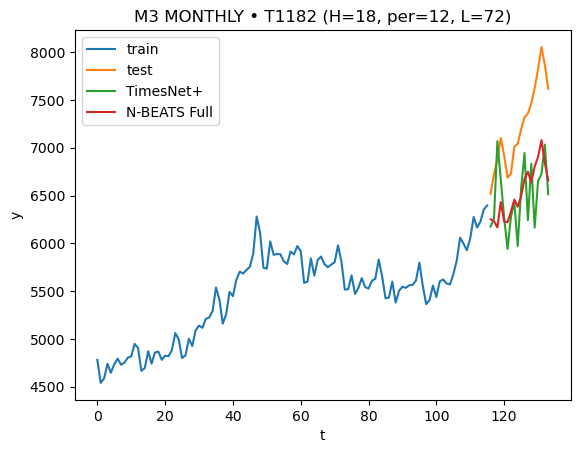

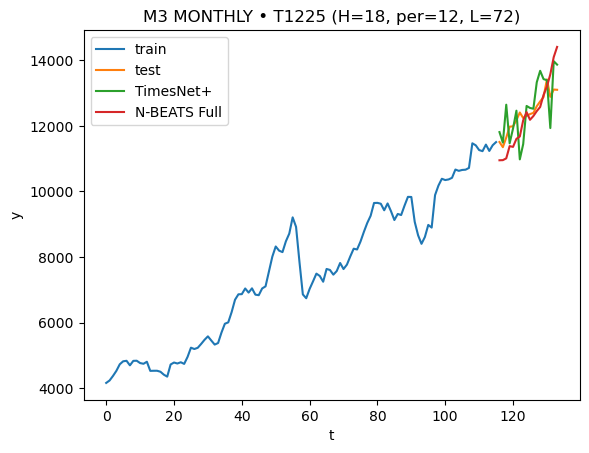

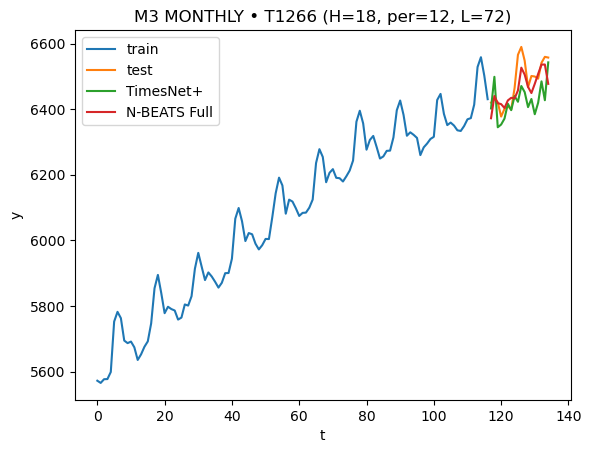

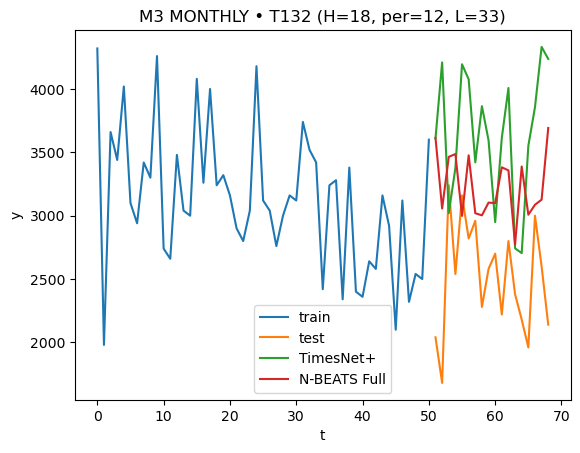

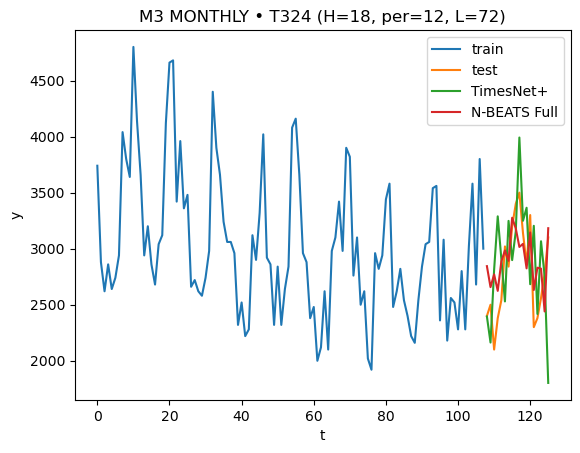

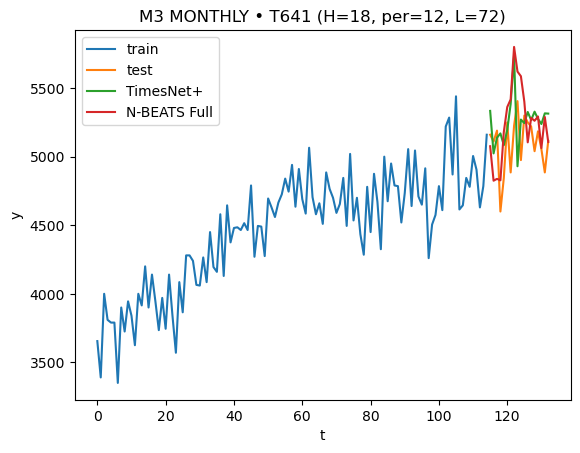

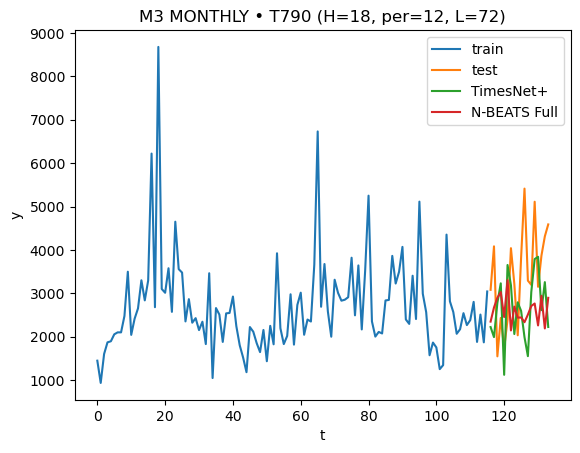

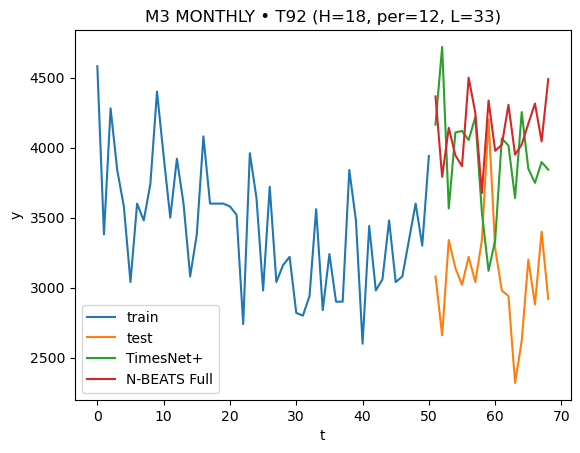

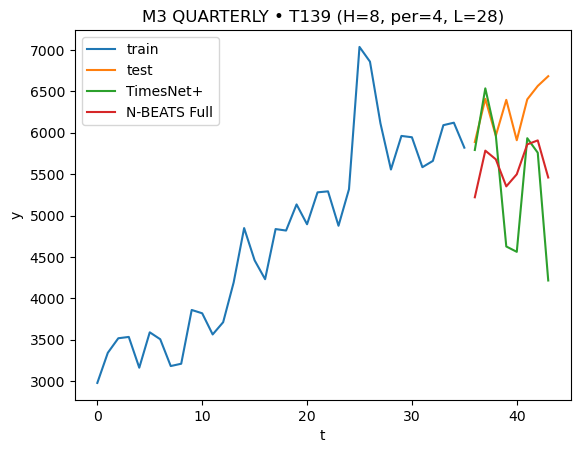

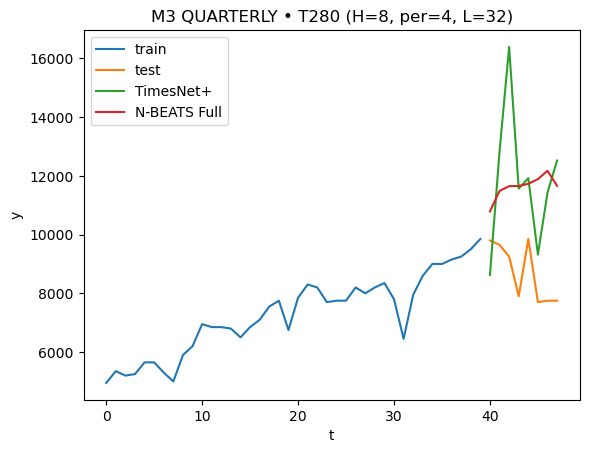

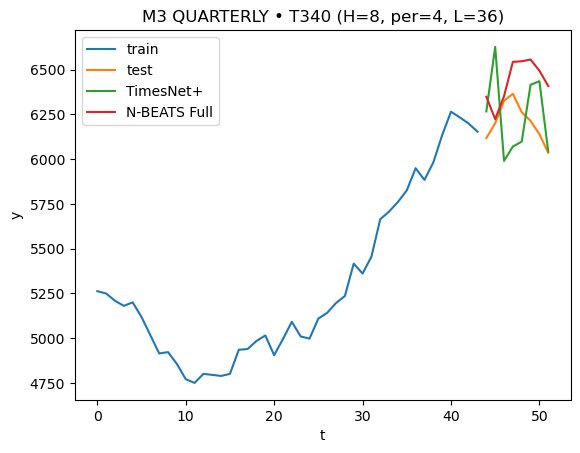

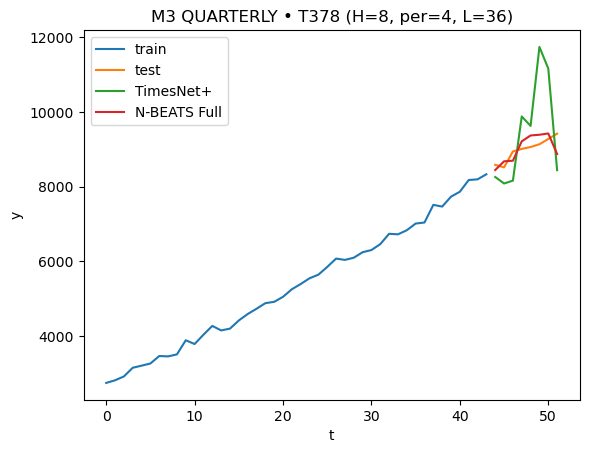

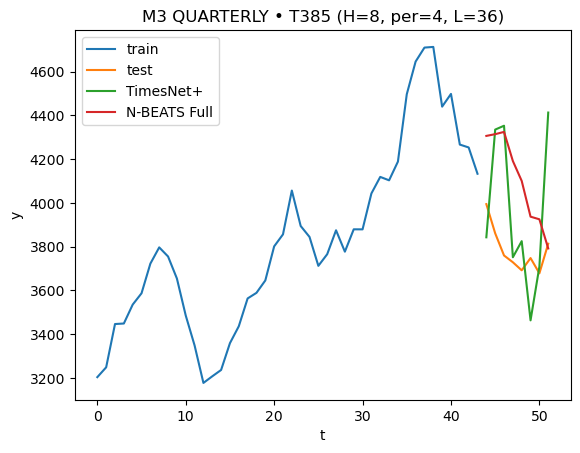

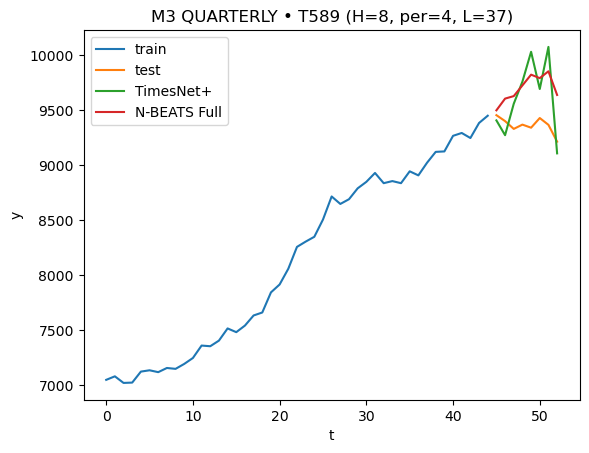

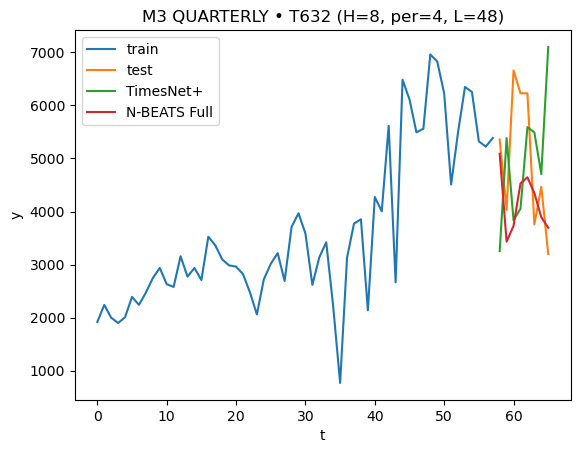

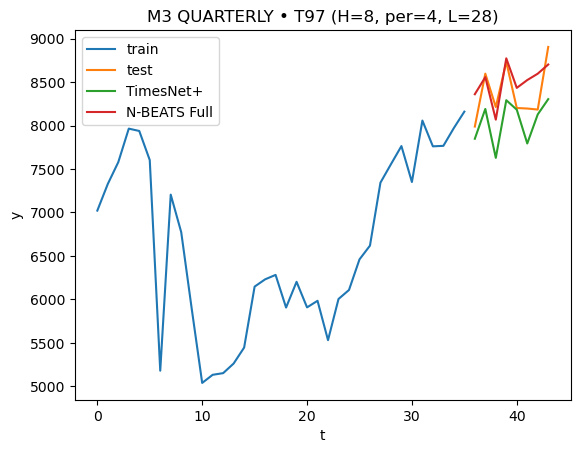

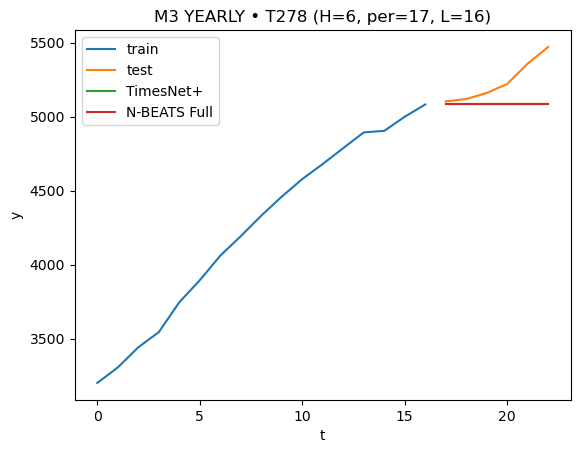

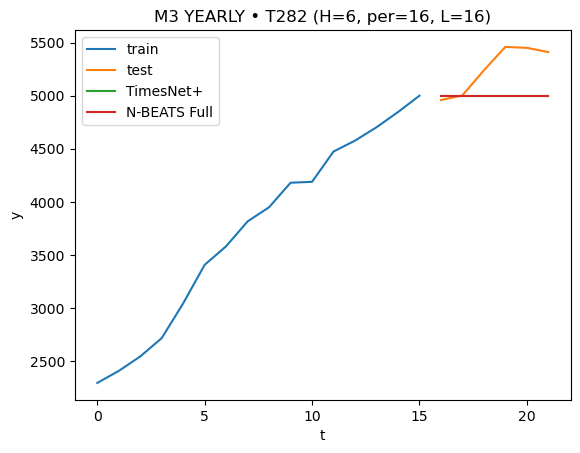

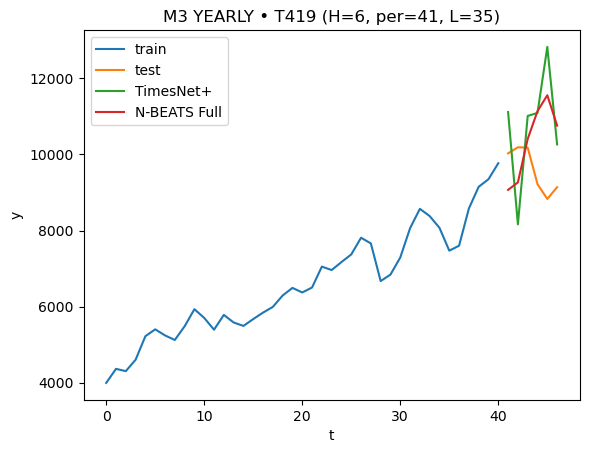

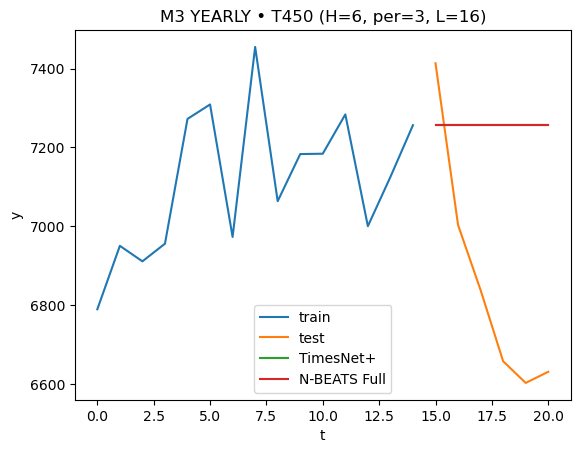

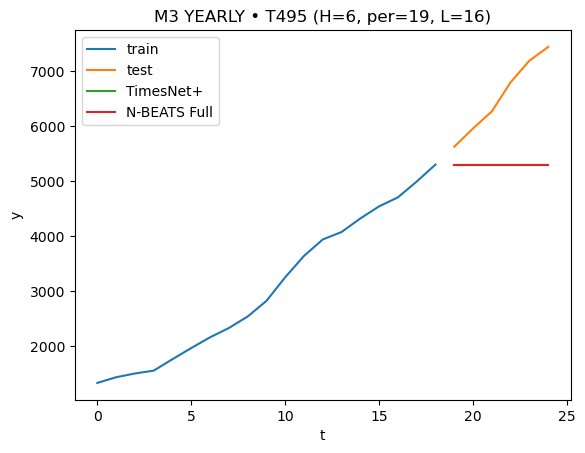

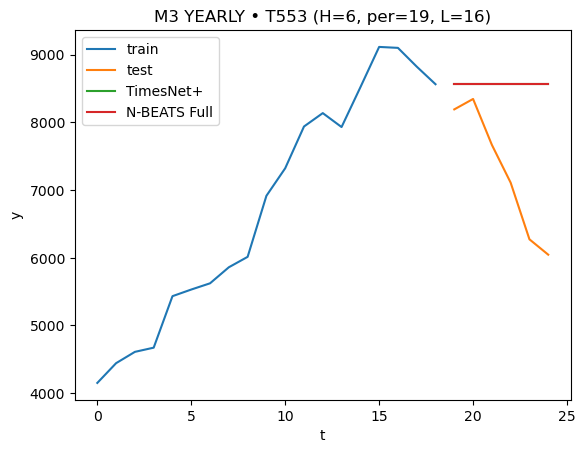

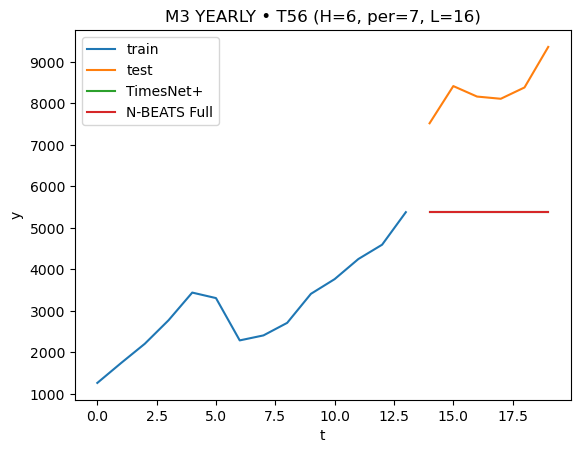

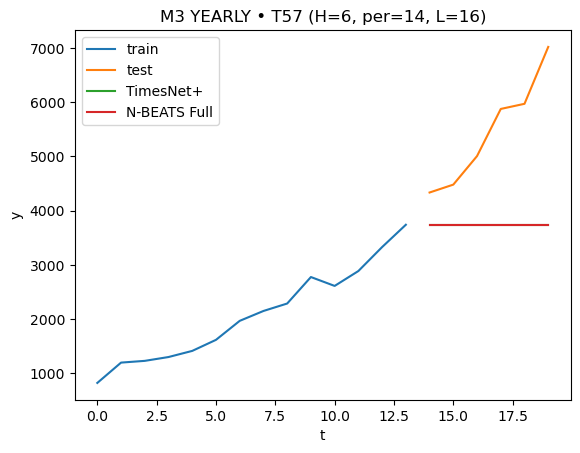

In [42]:
# быстрый прогон
df_m3 = eval_and_plot_m3(
    categories=("yearly","quarterly","monthly"),
    n_per_cat=8, pick="random", seed=42, epochs=6,
    out_prefix="/mnt/data/m3_ours"
)

# сводка
if not df_m3.empty:
    print(df_m3.groupby("category")[["TimesNet+_sMAPE","NBEATS_Full_sMAPE"]]
          .mean(numeric_only=True).round(3))
else:
    print("Нет результатов — проверь наличие TRAIN/TSTS CSV и ошибки в логах выше.")

# посмотреть картинки
imgs = sorted(glob.glob("/mnt/data/m3_ours_*.png"))
print(f"PNG plots: {len(imgs)}")
from IPython.display import Image, display
for p in imgs:
    display(Image(filename=p))
